This notebook is wayyyyy toooooo lonnnnnnggggggg

In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import astropy.units as u
import astropy.constants as co
import astropy.cosmology
import astropy.stats.biweight as biw
import connectivity
import os

from glob import glob

from os.path import expanduser

import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap
from astropy.coordinates import SkyCoord
from astropy.table import Table

# This is necessary to shut python up while running the fourth cell.
import warnings
warnings.filterwarnings("ignore")

In [6]:
cosm = astropy.cosmology.Planck15

In [7]:
home = expanduser('~')
path = os.path.join(home,'Dropbox','**','legit_final_table.csv')
filepath = glob(path, recursive=True)
gal_info = pd.read_csv(filepath[0], index_col=None)

gal_info.rename(columns={'OBJECT_x': 'OBJECT'}, inplace=True)
gal_info.rename(columns={'specfile_x': 'specfile'}, inplace=True)
gal_info.rename(columns={'gal_ra_x': 'gal_ra'}, inplace=True)
gal_info.rename(columns={'gal_dec_x': 'gal_dec'}, inplace=True)

Making a list of which galaxies are within the linking length in angular dist and within $1000 \; \frac{km}{s}$ in z/velocity space.

In [8]:
have_friends = []
for ii in range(len(gal_info)):
    # just compare galaxies around same QSO
    #small_info = gal_info[gal_info['id']==gal_info.OBJECT.loc[ii]]
    small_info = gal_info # :(
    c1 = SkyCoord(small_info.gal_ra.loc[ii]*u.deg, small_info.gal_dec.loc[ii]*u.deg)
    c2 = SkyCoord(small_info.gal_ra*u.deg, small_info.gal_dec*u.deg)
    sep = c1.separation(c2)
    friends = np.where(
        (((cosm.angular_diameter_distance(small_info['z'].loc[ii])*sep.radian).value)<(0.34*(1+1.4*np.arctan(small_info['z'].loc[ii]/0.09))))
        &
        (((cosm.scale_factor(small_info['z'].loc[ii])*np.abs(small_info['z']-small_info['z'].loc[ii])*co.c.to('km/s').value)<1000)
        &
        (small_info['z'].index != ii)
        )
    )
    if len(friends[0]) > 0:
        have_friends.append([ii,np.ravel(friends)])

Part where we find friends of friends and group them together:

In [9]:
have_friends = np.array(have_friends)

In [10]:
connectedness = connectivity.ConnectedComponents(np.arange(len(gal_info)))

In [11]:
for ii,ijs in have_friends:
    for ij in ijs:
        connectedness.add_edge(ii,ij)

In [12]:
inds,grps=connectedness.get_all_roots(reindex_root_values=True)

In [13]:
gal_info['friends_group'] = grps

Part where we find lots of interesting things about our friend groups (just the bigger ones to start with):

In [14]:
list_o_lists = []
id_list = []
for ii in range(len(gal_info)):
    bffs = gal_info.query('friends_group=='+str(ii))
    # set this to 5 for the large groups, 3 for all of the small ones too
    if len(bffs)>=5:
        zloc = biw.biweight_location(bffs.z)
        ra_loc = biw.biweight_location(bffs.gal_ra)
        dec_loc = biw.biweight_location(bffs.gal_dec)
        member_ids = bffs.id
        membermorphology = bffs.gal_type
        # do I need to worry about the scale factor here?
        vel_disp = biw.biweight_scale(bffs.z)*co.c.to('km/s')
        
        # cluster masses section:
        seplist=[]
        for ii in bffs.T:
            c1 = SkyCoord(bffs.gal_ra.loc[ii]*u.deg, bffs.gal_dec.loc[ii]*u.deg)
            c2 = SkyCoord(bffs.gal_ra*u.deg, bffs.gal_dec*u.deg)
            sep = c1.separation(c2)
            seplist.append(np.max(sep.radian))
        rad = np.max(seplist)*cosm.angular_diameter_distance(biw.biweight_location(bffs.z))/2
        # if I'm misrepresenting the virial theorem here blame Jess' slides
        mass = (5/3)*rad*(vel_disp**2)/co.G
        logmass = np.log10(mass.to('M_sun').value)
        
        QSO = bffs.OBJECT.loc[ii]
        
        # info about location of cluster's most massive member:
        biggest_boi_idx = bffs.mstars.idxmax()
        biggest_boi = bffs.loc[biggest_boi_idx]
        # separation betwixt the center and the biggest boi:
        grp_cent = SkyCoord(ra_loc*u.deg, dec_loc*u.deg)
        biggest_loc = SkyCoord(biggest_boi.gal_ra*u.deg,biggest_boi.gal_dec*u.deg)
        center_diff = grp_cent.separation(biggest_loc)
        center_diff_mpc = center_diff.radian*cosm.angular_diameter_distance(zloc)
        list_o_lists.append([len(bffs),QSO,zloc,biggest_boi.z,vel_disp,rad,logmass,ra_loc,dec_loc,biggest_boi.gal_ra,biggest_boi.gal_dec,center_diff_mpc,member_ids,membermorphology,biggest_boi.gal_type])

In [15]:
listkeys = ['party_size','QSO','redshift_guess','biggest_boi_z','vel_disp','radius','logmass','center_ra','center_dec','biggest_boi_gal_ra','biggest_boi_gal_dec','center_diff_mpc','member_ids','morphology','biggest_boi_morphology']

In [16]:
big_dtf = pd.DataFrame(list_o_lists,columns=listkeys)

In [17]:
big_dtf

,party_size,QSO,redshift_guess,biggest_boi_z,vel_disp,radius,logmass,center_ra,center_dec,biggest_boi_gal_ra,biggest_boi_gal_dec,center_diff_mpc,member_ids,morphology,biggest_boi_morphology
0,5,J0843+4117,0.541737,0.539816,360.04584297820315 km / s,0.722004609960654 Mpc,13.559543,130.941802,41.319185,130.974518,41.320671,0.5807582189335815 Mpc,57 J084340.92+411951.6._05 61 J084342....,57 b'SF' 61 b'SF' 75 b'SF+E' 8...,b'SF'
1,8,J0843+4117,0.807485,0.807099,503.8134162083585 km / s,0.8386772935155622 Mpc,13.916422,130.974259,41.286176,130.974472,41.283920,0.06307156672222673 Mpc,59 J084341.89+411628.9._04 73 J084345....,59 b'SF+E' 73 b'SF+E' 78 b'SF' 9...,b'SF'
2,5,J0914+2823,0.510012,0.509319,150.76630517177458 km / s,0.7520359746396579 Mpc,12.821135,138.705930,28.389861,138.706863,28.411850,0.5033450096284552 Mpc,136 J091435.68+282229.9._01 155 J091446....,136 b'SF+E' 155 b'SF' 161 b'SF' 1...,b'SF'
3,5,J0935+0204,0.225748,0.225570,358.71761577068156 km / s,0.4025263840445176 Mpc,13.302587,143.803112,2.087740,143.811066,2.089780,0.11043159248548431 Mpc,168 J093510.25+020630.5._09 170 J093511....,168 b'SF' 170 b'SF+E' 172 b'SF' 1...,b'SF'
4,5,J0935+0204,0.424802,0.424721,136.63079844809084 km / s,0.30944937229167885 Mpc,12.349974,143.840164,2.078813,143.845688,2.072880,0.16748516463364543 Mpc,186 J093518.97+020500.9._09 191 J093521....,186 b'SF' 191 b'SF' 192 b'SF' 195 ...,b'SF'
5,5,J1001+5944,0.374205,0.375555,51.016126529871144 km / s,0.5688901390254302 Mpc,11.758731,150.219894,59.734655,150.167892,59.747490,0.5582834513509644 Mpc,224 J100040.30+594451.0._12 227 J100047....,224 b'SF' 227 b'SF' 228 b'SF' 2...,b'SF'
6,7,J1001+5944,0.282140,0.281961,227.87300270008683 km / s,0.5353871986951582 Mpc,13.032341,150.301684,59.736018,150.301437,59.760860,0.3936250497089242 Mpc,235 J100054.87+594436.7._10 241 J100100....,235 b'SF+E' 241 b'SF' 257 b'SF+E' 2...,b'SF+E'
7,6,J1001+5944,0.304297,0.305044,240.0750518356186 km / s,0.26566115918382893 Mpc,12.773310,150.260730,59.723170,150.258621,59.717300,0.0996189150353009 Mpc,237 J100057.19+594233.8._11 239 J100100....,237 b'SF+E' 239 b'SF+E' 243 b'SF' 2...,b'SF'
8,15,J1016+4706,0.165925,0.165040,726.2560273933645 km / s,0.41544731779837357 Mpc,13.928983,154.097618,47.098664,154.098694,47.079948,0.19775972735461889 Mpc,276 J101614.74+470515.3._13 278 J101614....,276 b'SF+E' 278 b'SF+E' 282 b'SF' 2...,b'SF'
9,10,J1112+3539,0.449350,0.449440,652.1737772900967 km / s,0.43644447797189273 Mpc,13.856943,165.014694,35.661318,165.014694,35.680431,0.40803067182833663 Mpc,419 J111231.19+354049.6._19 421 J111231....,419 b'SF+E' 421 b'SF+E' 423 b'SF+E' 4...,b'SF+E'


### things to look at:

look for isolated hosts (next smallest 1/3 in stellar mass)
look at angles and see what's up, use astropy position angle
from that, absorption! Could use distance to host and galaxy, or distance to host and position angle to galaxy
hosts don't necessarily need to be isolated for abs. part

In [18]:
# let's see what Kirill got:

party_directory = pd.read_csv('./py_files/candidate_groups.txt')

In [19]:
party_directory

,QSO,size_guess,redshift_guess
0,J0843+4117,7,0.542320
1,J0843+4117,6,0.807626
2,J1001+5944,8,0.282191
3,J1001+5944,7,0.304520
4,J1016+4706,22,0.166070
5,J1112+3539,21,0.448303
6,J1133+0327,10,0.236273
7,J1133+0327,6,0.349436
8,J1134+2555,7,0.426730
9,J1134+2555,9,0.501406


yeah that's not quite the same oh well

### Conformity of larger groups:

In [20]:
for ii in range(len(big_dtf)):
    print(big_dtf.morphology[ii])

57       b'SF'
61       b'SF'
75     b'SF+E'
86       b'SF'
103      b'SF'
Name: gal_type, dtype: object
59     b'SF+E'
73     b'SF+E'
78       b'SF'
99       b'SF'
102      b'SF'
104    b'SF+E'
106      b'SF'
108    b'SF+E'
Name: gal_type, dtype: object
136    b'SF+E'
155      b'SF'
161      b'SF'
162      b'SF'
164    b'SF+E'
Name: gal_type, dtype: object
168      b'SF'
170    b'SF+E'
172      b'SF'
174      b'SF'
177      b'SF'
Name: gal_type, dtype: object
186    b'SF'
191    b'SF'
192    b'SF'
195    b'SF'
199    b'SF'
Name: gal_type, dtype: object
224      b'SF'
227      b'SF'
228      b'SF'
250    b'SF+E'
252      b'SF'
Name: gal_type, dtype: object
235    b'SF+E'
241      b'SF'
257    b'SF+E'
261    b'SF+E'
263    b'SF+E'
265    b'SF+E'
270      b'SF'
Name: gal_type, dtype: object
237    b'SF+E'
239    b'SF+E'
243      b'SF'
245      b'SF'
246      b'SF'
251      b'SF'
Name: gal_type, dtype: object
276    b'SF+E'
278    b'SF+E'
282      b'SF'
285      b'SF'
286      b'SF'
287  

### Now for the wee little groups!

In [75]:
list_o_lists = []
id_list = []
for ii in range(len(gal_info)):
    bffs = gal_info.query('friends_group=='+str(ii))
    # set this to 5 for the large groups, 3 for all of the small ones too
    if len(bffs)>=3:
        zloc = biw.biweight_location(bffs.z)
        ra_loc = biw.biweight_location(bffs.gal_ra)
        dec_loc = biw.biweight_location(bffs.gal_dec)
        member_ids = bffs.id
        membermorphology = bffs.gal_type
        memberstellarmasses = bffs.mstars
        vel_disp = biw.biweight_scale(bffs.z)*co.c.to('km/s')
        
        # cluster masses section:
        seplist=[]
        for ii in bffs.T:
            c1 = SkyCoord(bffs.gal_ra.loc[ii]*u.deg, bffs.gal_dec.loc[ii]*u.deg)
            c2 = SkyCoord(bffs.gal_ra*u.deg, bffs.gal_dec*u.deg)
            sep = c1.separation(c2)
            seplist.append(np.max(sep.radian))
        rad = np.max(seplist)*cosm.angular_diameter_distance(biw.biweight_location(bffs.z))/2
        # if I'm misrepresenting the virial theorem here blame Jess' slides
        mass = (5/3)*rad*(vel_disp**2)/co.G
        logmass = np.log10(mass.to('M_sun').value)
        
        QSO = bffs.OBJECT.loc[ii]
        
        # smallest impact parameter w.r.t. QSO:
        minpact_parameter = bffs.rho_impact.nsmallest(1)
        # info about location of cluster's most massive member:
        biggest_boi_idx = bffs.mstars.idxmax()
        biggest_boi = bffs.loc[biggest_boi_idx]
        # separation betwixt the center and the biggest boi:
        grp_cent = SkyCoord(ra_loc*u.deg, dec_loc*u.deg)
        biggest_loc = SkyCoord(biggest_boi.gal_ra*u.deg,biggest_boi.gal_dec*u.deg)
        center_diff = grp_cent.separation(biggest_loc)
        center_diff_mpc = center_diff.radian*cosm.angular_diameter_distance(zloc)
        # impact parameter btwn center & QSO:
        QSOloc = SkyCoord(bffs.RA_QSO.loc[ii]*u.deg,bffs.DEC_QSO.loc[ii]*u.deg)
        center_QSO = grp_cent.separation(QSOloc)
        center_QSO_rho = center_QSO.radian*cosm.angular_diameter_distance(zloc).value
        list_o_lists.append([len(bffs),QSO,zloc,biggest_boi.z,vel_disp,rad,logmass,ra_loc,dec_loc,biggest_boi.gal_ra,biggest_boi.gal_dec,center_diff_mpc,member_ids,membermorphology,biggest_boi.gal_type,memberstellarmasses,minpact_parameter,center_QSO_rho])

In [76]:
listkeys = ['party_size','QSO','redshift_guess','biggest_boi_z','vel_disp','radius','logmass','center_ra','center_dec','biggest_boi_gal_ra','biggest_boi_gal_dec','center_diff_mpc','member_ids','morphology','biggestgaltype','stellar_masses','QSOrho_min','center_QSO_rho']

In [77]:
wee_little_groups = pd.DataFrame(list_o_lists,columns=listkeys)

In [78]:
wee_little_groups

,party_size,QSO,redshift_guess,biggest_boi_z,vel_disp,radius,logmass,center_ra,center_dec,biggest_boi_gal_ra,biggest_boi_gal_dec,center_diff_mpc,member_ids,morphology,biggestgaltype,stellar_masses,QSOrho_min,center_QSO_rho
0,3,J0226+0015,0.352969,0.349424,434.27875527748006 km / s,0.47554728663794493 Mpc,13.541019,36.550684,0.249508,36.550751,0.251680,0.040052623315028735 Mpc,0 J022601.51+001532.5._03 10 J022612.15...,0 b'SF' 10 b'SF' 12 b'SF+E' Name...,b'SF+E',0 8.405740 10 8.493776 12 9.237293 N...,"12 212.200456 Name: rho_impact, dtype: float64",0.239549
1,3,J0226+0015,0.297729,0.297832,82.10966884351586 km / s,0.5454572807064169 Mpc,12.153837,36.534892,0.259185,36.510059,0.260170,0.40884518542015885 Mpc,1 J022602.41+001536.6._01 3 J022607.08...,1 b'SF+E' 3 b'SF' 18 b'SF' Name...,b'SF+E',1 10.386827 3 8.162347 18 8.84550...,"18 309.147669 Name: rho_impact, dtype: float64",0.417939
2,3,J0809+4619,0.520972,0.520903,170.96243529961782 km / s,0.4460492822060432 Mpc,12.703472,122.302953,46.331768,122.327316,46.334530,0.3942891142330133 Mpc,30 J080905.28+461944.8._01 39 J080913.54...,30 b'SF' 39 b'SF' 49 b'SF' Name: gal_...,b'SF',30 8.682405 39 8.705125 49 9.479523 N...,"30 226.299365 Name: rho_impact, dtype: float64",0.355759
3,3,J0809+4619,0.532704,0.530117,64.25117503448554 km / s,0.2425109703073517 Mpc,11.588781,122.316879,46.342665,122.326057,46.326328,0.4099305197415455 Mpc,40 J080913.68+462032.5._04 44 J080916.16...,40 b'SF+E' 44 b'SF' 47 b'SF+E' Name...,b'SF+E',40 9.084104 44 9.159035 47 11.03056...,"40 572.241914 Name: rho_impact, dtype: float64",0.691767
4,5,J0843+4117,0.541737,0.539816,360.04584297820315 km / s,0.722004609960654 Mpc,13.559543,130.941802,41.319185,130.974518,41.320671,0.5807582189335815 Mpc,57 J084340.92+411951.6._05 61 J084342....,57 b'SF' 61 b'SF' 75 b'SF+E' 8...,b'SF',57 10.816021 61 8.819493 75 8.94...,"86 73.018686 Name: rho_impact, dtype: float64",0.627210
5,8,J0843+4117,0.807485,0.807099,503.8134162083585 km / s,0.8386772935155622 Mpc,13.916422,130.974259,41.286176,130.974472,41.283920,0.06307156672222673 Mpc,59 J084341.89+411628.9._04 73 J084345....,59 b'SF+E' 73 b'SF+E' 78 b'SF' 9...,b'SF',59 10.029536 73 9.363355 78 10.77...,"102 490.254337 Name: rho_impact, dtype: flo...",0.449945
6,3,J0843+4117,0.593428,0.593416,587.4728056954765 km / s,0.4896173058758222 Mpc,13.816120,130.961451,41.332694,130.936050,41.334000,0.471335122535602 Mpc,69 J084344.65+412002.4._05 90 J084350....,69 b'SF' 90 b'SF' 117 b'SF' Name: g...,b'SF',69 10.393711 90 8.713455 117 9.35...,"90 899.830087 Name: rho_impact, dtype: float64",0.936858
7,4,J0843+4117,0.579206,0.580030,741.130979407261 km / s,0.6160718164183764 Mpc,14.117709,130.958811,41.305138,130.938828,41.329262,0.6925436901812984 Mpc,74 J084345.32+411945.3._04 84 J084348....,74 b'SF' 84 b'SF' 97 b'SF+E' 1...,b'SF',74 10.899514 84 9.720776 97 9.87...,"101 375.549683 Name: rho_impact, dtype: flo...",0.254085
8,4,J0843+4117,0.300782,0.304114,774.4812148770999 km / s,0.36306714026127324 Mpc,13.926296,130.978158,41.284091,130.975021,41.275631,0.14549831498045593 Mpc,79 J084346.79+411735.0._06 105 J084354....,79 b'SF' 105 b'SF' 110 b'SF' 1...,b'SF',79 8.385152 105 10.016991 110 9.46...,"79 142.414824 Name: rho_impact, dtype: float64",0.326796
9,3,J0843+4117,0.455167,0.454648,100.59593301093065 km / s,0.2937173137685766 Mpc,12.061378,130.960342,41.307174,130.962006,41.318649,0.24820588956443937 Mpc,88 J084349.68+411820.3._06 93 J084350....,88 b'SF' 93 b'SF' 116 b'SF' Name: g...,b'SF',88 8.406583 93 9.080961 116 8.65088...,"88 231.079987 Name: rho_impact, dtype: float64",0.272291


Investigating group 41 real quick because it's messed up

In [79]:
for ii in range(len(wee_little_groups)):
    big_enough = (10**(wee_little_groups.stellar_masses[ii].nlargest(2).min()))/(10**(wee_little_groups.stellar_masses[ii].nlargest(2).max()))
    if big_enough==1:
        print(ii)

41


In [80]:
wee_little_groups.stellar_masses[41].nlargest(2).min(),wee_little_groups.stellar_masses[41].nlargest(2).max()

(9.432034026537147, 9.432034026537147)

Looks like 534 & 535 aren't the same probably but were given the same stellar mass?

### Anyway back to finding the <1/3 ones

In [81]:
idx_list = []
mass_ratios = []
for ii in range(len(wee_little_groups)):
    big_enough = (10**(wee_little_groups.stellar_masses[ii].nlargest(2).min()))/(10**(wee_little_groups.stellar_masses[ii].nlargest(2).max()))
    if big_enough<0.33:
        idx_list.append(ii)
        mass_ratios.append(big_enough)

In [82]:
blue_hosts = wee_little_groups.loc[idx_list]
blue_hosts['host_vs_2nd_largest'] = mass_ratios

In [83]:
len(blue_hosts)

34

This is not a particularly large number but whatever

In [84]:
blue_hosts

,party_size,QSO,redshift_guess,biggest_boi_z,vel_disp,radius,logmass,center_ra,center_dec,biggest_boi_gal_ra,biggest_boi_gal_dec,center_diff_mpc,member_ids,morphology,biggestgaltype,stellar_masses,QSOrho_min,center_QSO_rho,host_vs_2nd_largest
0,3,J0226+0015,0.352969,0.349424,434.27875527748006 km / s,0.47554728663794493 Mpc,13.541019,36.550684,0.249508,36.550751,0.251680,0.040052623315028735 Mpc,0 J022601.51+001532.5._03 10 J022612.15...,0 b'SF' 10 b'SF' 12 b'SF+E' Name...,b'SF+E',0 8.405740 10 8.493776 12 9.237293 N...,"12 212.200456 Name: rho_impact, dtype: float64",0.239549,0.180502
1,3,J0226+0015,0.297729,0.297832,82.10966884351586 km / s,0.5454572807064169 Mpc,12.153837,36.534892,0.259185,36.510059,0.260170,0.40884518542015885 Mpc,1 J022602.41+001536.6._01 3 J022607.08...,1 b'SF+E' 3 b'SF' 18 b'SF' Name...,b'SF+E',1 10.386827 3 8.162347 18 8.84550...,"18 309.147669 Name: rho_impact, dtype: float64",0.417939,0.028752
2,3,J0809+4619,0.520972,0.520903,170.96243529961782 km / s,0.4460492822060432 Mpc,12.703472,122.302953,46.331768,122.327316,46.334530,0.3942891142330133 Mpc,30 J080905.28+461944.8._01 39 J080913.54...,30 b'SF' 39 b'SF' 49 b'SF' Name: gal_...,b'SF',30 8.682405 39 8.705125 49 9.479523 N...,"30 226.299365 Name: rho_impact, dtype: float64",0.355759,0.168113
3,3,J0809+4619,0.532704,0.530117,64.25117503448554 km / s,0.2425109703073517 Mpc,11.588781,122.316879,46.342665,122.326057,46.326328,0.4099305197415455 Mpc,40 J080913.68+462032.5._04 44 J080916.16...,40 b'SF+E' 44 b'SF' 47 b'SF+E' Name...,b'SF+E',40 9.084104 44 9.159035 47 11.03056...,"40 572.241914 Name: rho_impact, dtype: float64",0.691767,0.013442
6,3,J0843+4117,0.593428,0.593416,587.4728056954765 km / s,0.4896173058758222 Mpc,13.816120,130.961451,41.332694,130.936050,41.334000,0.471335122535602 Mpc,69 J084344.65+412002.4._05 90 J084350....,69 b'SF' 90 b'SF' 117 b'SF' Name: g...,b'SF',69 10.393711 90 8.713455 117 9.35...,"90 899.830087 Name: rho_impact, dtype: float64",0.936858,0.091290
7,4,J0843+4117,0.579206,0.580030,741.130979407261 km / s,0.6160718164183764 Mpc,14.117709,130.958811,41.305138,130.938828,41.329262,0.6925436901812984 Mpc,74 J084345.32+411945.3._04 84 J084348....,74 b'SF' 84 b'SF' 97 b'SF+E' 1...,b'SF',74 10.899514 84 9.720776 97 9.87...,"101 375.549683 Name: rho_impact, dtype: flo...",0.254085,0.142579
12,4,J0914+2823,0.600128,0.599377,210.4741084339208 km / s,0.4752470294288141 Mpc,12.911604,138.652848,28.389869,138.656982,28.384680,0.15706069860002936 Mpc,137 J091436.16+282334.9._02 138 J091436....,137 b'SF' 138 b'SF' 141 b'SF' 151 ...,b'SF',137 10.191614 138 9.490131 141 11.04...,"141 303.581866 Name: rho_impact, dtype: flo...",0.340196,0.138638
13,3,J0914+2823,0.227620,0.228207,240.27501987336456 km / s,0.251752369433876 Mpc,12.750678,138.694743,28.413870,138.675736,28.414169,0.22641968877730564 Mpc,149 J091442.18+282451.0._02 153 J091446....,149 b'SF+E' 153 b'SF' 163 b'SF' N...,b'SF+E',149 11.202757 153 9.994957 163 9.86...,"149 315.719541 Name: rho_impact, dtype: flo...",0.433909,0.061973
14,3,J0914+2823,0.310807,0.311144,561.4205251140576 km / s,0.44549509983645014 Mpc,13.735707,138.688157,28.386134,138.689453,28.385309,0.023841491589075694 Mpc,150 J091442.85+282231.7._01 152 J091445....,150 b'SF+E' 152 b'SF' 154 b'SF' N...,b'SF',150 8.158745 152 11.682953 154 8.63...,"150 314.999336 Name: rho_impact, dtype: flo...",0.311530,0.000895
16,3,J0935+0204,0.353180,0.349514,822.0843914831577 km / s,0.3401254094698518 Mpc,13.949760,143.823312,2.086358,143.810104,2.082890,0.2516893774364515 Mpc,176 J093514.43+020458.4._08 181 J093516....,176 b'SF' 181 b'SF+E' 197 b'SF' N...,b'SF',176 11.811457 181 10.423237 197 9.15...,"176 360.920261 Name: rho_impact, dtype: flo...",0.287324,0.040905


In [85]:
biggalaxy=gal_info[gal_info['id']==blue_hosts.member_ids[0].loc[12]]
galaxy2=gal_info[gal_info['id']==blue_hosts.member_ids[0].loc[10]]
galaxy3=gal_info[gal_info['id']==blue_hosts.member_ids[0].loc[0]]

In [86]:
big_loc = SkyCoord(biggalaxy.gal_ra*u.deg, biggalaxy.gal_dec*u.deg)
gal2loc = SkyCoord(galaxy2.gal_ra*u.deg, galaxy2.gal_dec*u.deg)
gal3loc = SkyCoord(galaxy3.gal_ra*u.deg, galaxy3.gal_dec*u.deg)

Let's plot those and see what's up

In [87]:
centercoords = SkyCoord(blue_hosts.center_ra.loc[0]*u.deg,blue_hosts.center_dec.loc[0]*u.deg)

In [88]:
QSOordinates = SkyCoord(gal_info.RA_QSO.loc[0]*u.deg,gal_info.DEC_QSO.loc[0]*u.deg)

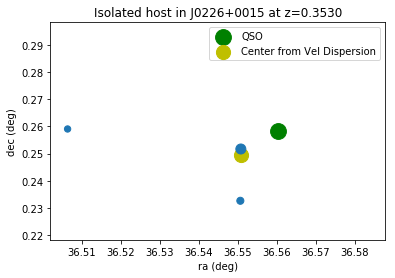

In [89]:
plt.scatter(QSOordinates.ra,QSOordinates.dec,c='g',s=250,label='QSO')
plt.scatter(centercoords.ra,centercoords.dec,c='y',s=200,label='Center from Vel Dispersion')
plt.scatter([big_loc.ra,gal2loc.ra,gal3loc.ra],[big_loc.dec,gal2loc.dec,gal3loc.dec],s=[100,50,40])
plt.legend()
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Isolated host in {0:s} at z={1:.4f}'.format(gal_info.OBJECT.loc[0],blue_hosts.redshift_guess.loc[0]));

Doing another one manually:

In [90]:
blue_hosts.member_ids.loc[42],blue_hosts.stellar_masses[42].nlargest(1)

(540    J123304.09-003326.0._10
 543    J123306.33-003201.1._09
 544    J123306.48-003146.1._10
 548    J123310.91-003308.9._09
 Name: id, dtype: object, 548    10.200419
 Name: mstars, dtype: float64)

In [91]:
bigg42=gal_info[gal_info['id']==blue_hosts.member_ids[42].loc[548]]
g42_2=gal_info[gal_info['id']==blue_hosts.member_ids[42].loc[540]]
g42_3=gal_info[gal_info['id']==blue_hosts.member_ids[42].loc[543]]
g42_4=gal_info[gal_info['id']==blue_hosts.member_ids[42].loc[544]]

In [92]:
big42_loc = SkyCoord(bigg42.gal_ra*u.deg, bigg42.gal_dec*u.deg)
g42_2loc = SkyCoord(g42_2.gal_ra*u.deg, g42_2.gal_dec*u.deg)
g42_3loc = SkyCoord(g42_3.gal_ra*u.deg, g42_3.gal_dec*u.deg)
g42_4loc = SkyCoord(g42_4.gal_ra*u.deg, g42_4.gal_dec*u.deg)

In [93]:
posangles2=big42_loc.position_angle(g42_2loc).degree
posangles3=big42_loc.position_angle(g42_3loc).degree
posangles4=big42_loc.position_angle(g42_4loc).degree

In [94]:
centercoords42 = SkyCoord(blue_hosts.center_ra.loc[42]*u.deg,blue_hosts.center_dec.loc[42]*u.deg)
QSOordinates42 = SkyCoord(gal_info.RA_QSO.loc[548]*u.deg,gal_info.DEC_QSO.loc[548]*u.deg)

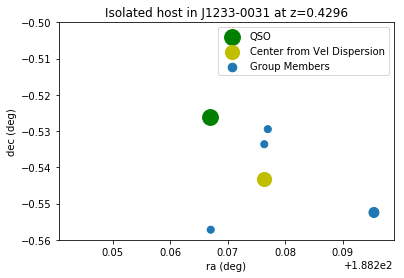

In [95]:
plt.scatter(QSOordinates42.ra,QSOordinates42.dec,c='g',s=250,label='QSO')
plt.scatter(centercoords42.ra,centercoords42.dec,c='y',s=200,label='Center from Vel Dispersion')
plt.scatter([big42_loc.ra,g42_2loc.ra,g42_3loc.ra,g42_4loc.ra],[big42_loc.dec,g42_2loc.dec,g42_3loc.dec,g42_4loc.dec],s=[100,50,50,50],label='Group Members')
plt.legend()
plt.ylim(-0.56,-0.50)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Isolated host in {0:s} at z={1:.4f}'.format(gal_info.OBJECT.loc[548],blue_hosts.redshift_guess.loc[42]));

Defining same and opposite sides according to $\Delta \phi$, as illustrated in figure 3 of Brainerd & Samuels 2020.

In [96]:
# this is to say that there don't appear to be any red hosts
# (but actually some of those SF+Es could be though)

blue_hosts.biggestgaltype.unique()

array(["b'SF+E'", "b'SF'"], dtype=object)

### Gathering $\Delta$ position angles:

In [97]:
list_o_lists2 = []
dist_list = []
largest_dist_list = []
distmin = []
for ii in range(blue_hosts.index.max()+1):
    try:
        that_big_boiii = blue_hosts.stellar_masses.loc[ii].max()
        # WAIT WAIT this last fix messed some other ones up:
        #largestgalaxy = gal_info[(gal_info['mstars']==that_big_boiii)&(gal_info.specfile.isna()==False)]
        largestgalaxy = gal_info[gal_info['mstars']==that_big_boiii]
        smallbois = blue_hosts.stellar_masses.loc[ii].nsmallest(len(blue_hosts.stellar_masses.loc[ii])-1)
        
        # this is horrible and ugly, but it's the first way of doing this that I could get to work:
        stars = []
        for index,mass in enumerate(smallbois):
            stars.append(mass)
        small_bois = gal_info.loc[np.where(gal_info.mstars.isin(stars))]
        
        big_boi_loc = SkyCoord(largestgalaxy.gal_ra*u.deg, largestgalaxy.gal_dec*u.deg)
        small_bois_loc = SkyCoord(small_bois.gal_ra*u.deg, small_bois.gal_dec*u.deg)
        # distance:
        dist_rad = big_boi_loc.separation(small_bois_loc)
        dists_to_largest = dist_rad.radian*cosm.angular_diameter_distance(blue_hosts.redshift_guess.loc[ii]).value
        dist_list.append(dists_to_largest)
        largest_dist_list.append(np.max(dists_to_largest))
        distmin.append(np.min(dists_to_largest))
        # next calculate position angle betwixt big and small bois
        posanglelist = []
        for galaxy in small_bois_loc:
            posangle = big_boi_loc.position_angle(galaxy).degree
            posanglelist.append(posangle)
        deltaposanglelist = []
        try:
            for jj in range(len(posanglelist)):
                delta_posangle = posanglelist-posanglelist[jj]
                deltaposanglelist.append(delta_posangle)
        except ValueError:
            deltaposanglelist.append(np.nan)
        if deltaposanglelist == []:
            deltaposanglelist.append(np.nan)
        deltaposanglelist = np.array(deltaposanglelist)
        deltaposanglelist = deltaposanglelist[np.where((deltaposanglelist>0))]
        deltaposanglelist = np.where(deltaposanglelist>180,360-deltaposanglelist,deltaposanglelist)
        list_o_lists2.append(deltaposanglelist)
    except KeyError:
        continue

In [98]:
blue_hosts.loc[39] # all have exactly the same RA?

party_size                                                             3
QSO                                                           J1134+2555
redshift_guess                                                  0.682333
biggest_boi_z                                                    0.68619
vel_disp                                        37.14685365127767 km / s
radius                                           0.07194602335718978 Mpc
logmass                                                          10.5851
center_ra                                                        165.015
center_dec                                                        25.905
biggest_boi_gal_ra                                               165.015
biggest_boi_gal_dec                                               25.905
center_diff_mpc                                0.0006937468181190323 Mpc
member_ids             482    J113452.40+255418.0._08
491    J113455....
morphology             482    b'SF+E'
491      b'SF

In [99]:
blue_hosts['delta_pos_angles'] = list_o_lists2

In [100]:
blue_hosts['distances_to_largest'] = dist_list
blue_hosts['max_dist_to_largest'] = largest_dist_list
blue_hosts['min_dist'] = distmin
# group names
blue_hosts['group_name']=(blue_hosts.QSO+'_'+(blue_hosts.redshift_guess.round(4)).astype('str'))

For binning: [0,60] = same side, [60,120] = could go either way, [120,180] = opposite sides, remember SORT-OF-modulo 180

In [101]:
bins = [0.0001,30,60,90,120,150,180]

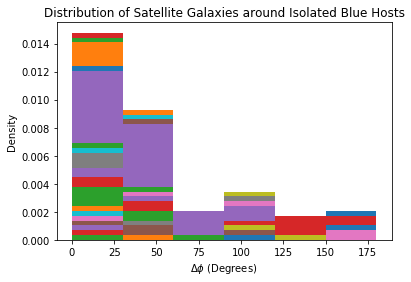

In [102]:
plt.hist(blue_hosts.query('party_size<11').delta_pos_angles,bins=bins,stacked=True, density=True)
plt.xlabel('$\Delta \phi$ (Degrees)')
plt.ylabel('Density')
plt.title('Distribution of Satellite Galaxies around Isolated Blue Hosts');

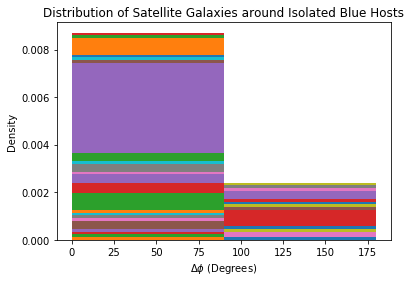

In [125]:
# now how about:

bins2 = [0.001,90,180]

plt.hist(blue_hosts.query('party_size<11').delta_pos_angles,bins=bins2,stacked=True,density=True)
plt.xlabel('$\Delta \phi$ (Degrees)')
plt.ylabel('Density')
plt.title('Distribution of Satellite Galaxies around Isolated Blue Hosts');

k...

In [104]:
# plotting the big one (i.e. the group of 10) just for fun

In [105]:
smallbois = blue_hosts.stellar_masses.loc[45].nsmallest(len(blue_hosts.stellar_masses.loc[45])-1)
stars = []
for index,mass in enumerate(smallbois):
    stars.append(mass)
small_bois = gal_info.loc[np.where(gal_info.mstars.isin(stars))]
small_bois_loc = SkyCoord(small_bois.gal_ra*u.deg, small_bois.gal_dec*u.deg)
QSOordinates45 = SkyCoord(gal_info.RA_QSO.loc[581]*u.deg,gal_info.DEC_QSO.loc[581]*u.deg)

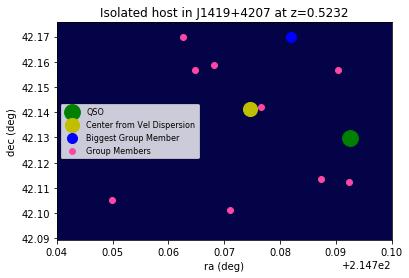

In [106]:
plt.scatter(QSOordinates45.ra,QSOordinates45.dec,c='g',s=250,label='QSO')
plt.scatter(blue_hosts.center_ra.loc[45],blue_hosts.center_dec.loc[45],c='y',s=200,label='Center from Vel Dispersion')
plt.scatter([blue_hosts.biggest_boi_gal_ra.loc[45]],[blue_hosts.biggest_boi_gal_dec.loc[45]],c='b',s=100,label='Biggest Group Member')
plt.scatter(small_bois_loc.ra,small_bois_loc.dec,c='xkcd:Barbie Pink',label='Group Members')
plt.legend(loc=6,fontsize=8)
plt.gca().set_facecolor('xkcd:night blue')
plt.xlim(214.74,214.8)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Isolated host in {0:s} at z={1:.4f}'.format(blue_hosts.QSO.loc[45],blue_hosts.redshift_guess.loc[45]));

In [107]:
# impact param of host
print(gal_info.rho_impact.loc[607])
# min impact param
print(blue_hosts.QSOrho_min.loc[45])

950.9344649172664
612    387.89927
Name: rho_impact, dtype: float64


And there is some absorption there.

#### Plotting the highest redshift because why not:

In [108]:
blue_hosts.nlargest(2,columns='redshift_guess')

,party_size,QSO,redshift_guess,biggest_boi_z,vel_disp,radius,logmass,center_ra,center_dec,biggest_boi_gal_ra,...,biggestgaltype,stellar_masses,QSOrho_min,center_QSO_rho,host_vs_2nd_largest,delta_pos_angles,distances_to_largest,max_dist_to_largest,min_dist,group_name
48,3,J1419+4207,0.844714,0.845320,663.2489729066789 km / s,0.467671855190145 Mpc,13.901582,214.792490,42.133696,214.789032,...,b'SF',613 10.209694 618 8.701060 625 9.39...,"613 122.414144 Name: rho_impact, dtype: flo...",0.113081,0.153806,[105.90687606352859],"[0.06382947751925189, 0.9158331774191497]",0.915833,0.063829,J1419+4207_0.8447
44,3,J1419+4207,0.804639,0.804798,78.79438613759665 km / s,0.500663331857725 Mpc,12.080824,214.760092,42.120558,214.740555,...,b'SF+E',577 11.653812 591 10.017536 593 9.63...,"593 691.657879 Name: rho_impact, dtype: flo...",0.716621,0.023106,[101.97514682702563],"[0.5918906202936364, 0.6941374452470978]",0.694137,0.591891,J1419+4207_0.8046


okay so here's 48, at $z=0.845$-ish in `J1419+4207`:

In [109]:
smallbois = blue_hosts.stellar_masses.loc[48].nsmallest(len(blue_hosts.stellar_masses.loc[48])-1)
stars = [] # note: stars as in stellar mass
for index,mass in enumerate(smallbois):
    stars.append(mass)
small_bois = gal_info.loc[np.where(gal_info.mstars.isin(stars))]
small_bois_loc = SkyCoord(small_bois.gal_ra*u.deg, small_bois.gal_dec*u.deg)
QSOordinates48 = SkyCoord(gal_info.RA_QSO.loc[625]*u.deg,gal_info.DEC_QSO.loc[625]*u.deg)

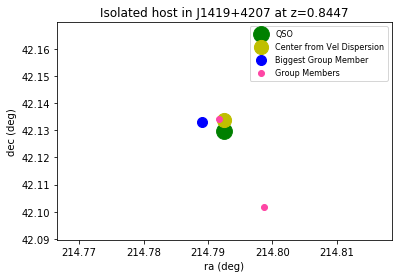

In [110]:
plt.scatter(QSOordinates48.ra,QSOordinates48.dec,c='g',s=250,label='QSO')
plt.scatter(blue_hosts.center_ra.loc[48],blue_hosts.center_dec.loc[48],c='y',s=200,label='Center from Vel Dispersion')
plt.scatter([blue_hosts.biggest_boi_gal_ra.loc[48]],[blue_hosts.biggest_boi_gal_dec.loc[48]],c='b',s=100,label='Biggest Group Member')
plt.scatter(small_bois_loc.ra,small_bois_loc.dec,c='xkcd:Barbie Pink',label='Group Members')
plt.legend(fontsize=8)
#plt.xlim(214.74,214.8)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Isolated host in {0:s} at z={1:.4f}'.format(blue_hosts.QSO.loc[48],blue_hosts.redshift_guess.loc[48]));

In [111]:
smallbois = blue_hosts.stellar_masses.loc[44].nsmallest(len(blue_hosts.stellar_masses.loc[44])-1)
stars = [] # note: stars as in stellar mass
for index,mass in enumerate(smallbois):
    stars.append(mass)
small_bois = gal_info.loc[np.where(gal_info.mstars.isin(stars))]
small_bois_loc = SkyCoord(small_bois.gal_ra*u.deg, small_bois.gal_dec*u.deg)
QSOordinates44 = SkyCoord(gal_info.RA_QSO.loc[591]*u.deg,gal_info.DEC_QSO.loc[591]*u.deg)

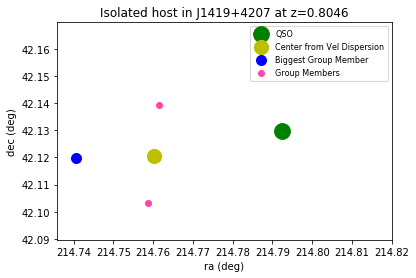

In [112]:
plt.scatter(QSOordinates44.ra,QSOordinates44.dec,c='g',s=250,label='QSO')
plt.scatter(blue_hosts.center_ra.loc[44],blue_hosts.center_dec.loc[44],c='y',s=200,label='Center from Vel Dispersion')
plt.scatter([blue_hosts.biggest_boi_gal_ra.loc[44]],[blue_hosts.biggest_boi_gal_dec.loc[44]],c='b',s=100,label='Biggest Group Member')
plt.scatter(small_bois_loc.ra,small_bois_loc.dec,c='xkcd:Barbie Pink',label='Group Members')
plt.legend(fontsize=8)
#plt.xlim(214.74,214.8)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Isolated host in {0:s} at z={1:.4f}'.format(blue_hosts.QSO.loc[44],blue_hosts.redshift_guess.loc[44]));

### Plotting a couple where minpact par is small but there is no absorption:

In [113]:
blue_hosts.query("group_name=='J0935+0204_0.2624'")

,party_size,QSO,redshift_guess,biggest_boi_z,vel_disp,radius,logmass,center_ra,center_dec,biggest_boi_gal_ra,...,biggestgaltype,stellar_masses,QSOrho_min,center_QSO_rho,host_vs_2nd_largest,delta_pos_angles,distances_to_largest,max_dist_to_largest,min_dist,group_name
18,3,J0935+0204,0.262358,0.262356,0.9201273020458339 km / s,0.15471800895647564 Mpc,7.705524,143.846282,2.084222,143.846161,...,b'SF',187 9.837980 196 10.530492 198 9.46...,"187 141.302724 Name: rho_impact, dtype: flo...",0.366572,0.202996,[173.1349631084515],"[0.2509522439927861, 0.058825625670392345]",0.250952,0.058826,J0935+0204_0.2624


In [114]:
smallbois = blue_hosts.stellar_masses.loc[18].nsmallest(len(blue_hosts.stellar_masses.loc[18])-1)
stars = [] # note: stars as in stellar mass
for index,mass in enumerate(smallbois):
    stars.append(mass)
small_bois = gal_info.loc[np.where(gal_info.mstars.isin(stars))]
small_bois_loc = SkyCoord(small_bois.gal_ra*u.deg, small_bois.gal_dec*u.deg)
QSOordinates18 = SkyCoord(gal_info.RA_QSO.loc[187]*u.deg,gal_info.DEC_QSO.loc[187]*u.deg)

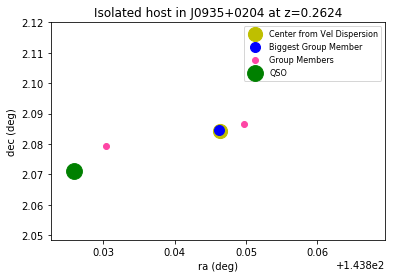

In [115]:
plt.scatter(blue_hosts.center_ra.loc[18],blue_hosts.center_dec.loc[18],c='y',s=200,label='Center from Vel Dispersion')
plt.scatter([blue_hosts.biggest_boi_gal_ra.loc[18]],[blue_hosts.biggest_boi_gal_dec.loc[18]],c='b',s=100,label='Biggest Group Member')
plt.scatter(small_bois_loc.ra,small_bois_loc.dec,c='xkcd:Barbie Pink',label='Group Members')
plt.scatter(QSOordinates18.ra,QSOordinates18.dec,c='g',s=250,label='QSO')
plt.legend(fontsize=8)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Isolated host in {0:s} at z={1:.4f}'.format(blue_hosts.QSO.loc[18],blue_hosts.redshift_guess.loc[18]));

And another:

In [116]:
blue_hosts.query("group_name=='J1001+5944_0.3742'")

,party_size,QSO,redshift_guess,biggest_boi_z,vel_disp,radius,logmass,center_ra,center_dec,biggest_boi_gal_ra,...,biggestgaltype,stellar_masses,QSOrho_min,center_QSO_rho,host_vs_2nd_largest,delta_pos_angles,distances_to_largest,max_dist_to_largest,min_dist,group_name
21,5,J1001+5944,0.374205,0.375555,51.016126529871144 km / s,0.5688901390254302 Mpc,11.758731,150.219894,59.734655,150.167892,...,b'SF',224 10.325436 227 9.442047 228 8.69...,"250 155.41042 Name: rho_impact, dtype: float64",0.395772,0.130801,"[16.32203968656009, 37.33424360178887, 21.0122...","[0.419926162047403, 0.402502113744618, 1.07011...",1.13778,0.402502,J1001+5944_0.3742


In [117]:
smallbois = blue_hosts.stellar_masses.loc[21].nsmallest(len(blue_hosts.stellar_masses.loc[21])-1)
stars = [] # note: stars as in stellar mass
for index,mass in enumerate(smallbois):
    stars.append(mass)
small_bois = gal_info.loc[np.where(gal_info.mstars.isin(stars))]
small_bois_loc = SkyCoord(small_bois.gal_ra*u.deg, small_bois.gal_dec*u.deg)
QSOordinates21 = SkyCoord(gal_info.RA_QSO.loc[250]*u.deg,gal_info.DEC_QSO.loc[250]*u.deg)

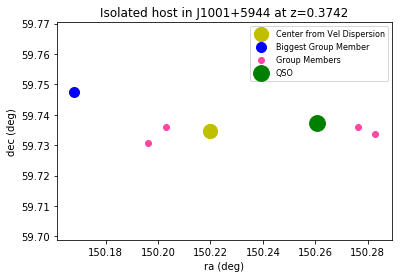

In [118]:
plt.scatter(blue_hosts.center_ra.loc[21],blue_hosts.center_dec.loc[21],c='y',s=200,label='Center from Vel Dispersion')
plt.scatter([blue_hosts.biggest_boi_gal_ra.loc[21]],[blue_hosts.biggest_boi_gal_dec.loc[21]],c='b',s=100,label='Biggest Group Member')
plt.scatter(small_bois_loc.ra,small_bois_loc.dec,c='xkcd:Barbie Pink',label='Group Members')
plt.scatter(QSOordinates21.ra,QSOordinates21.dec,c='g',s=250,label='QSO')
plt.legend(fontsize=8)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Isolated host in {0:s} at z={1:.4f}'.format(blue_hosts.QSO.loc[21],blue_hosts.redshift_guess.loc[21]));

### Finally adding an absorption flag column to blue hosts and saving it as a csv:

In [119]:
# for what absorption is actually present look at isolated_blue_host_abs.txt
absorption = ['yes',
'yes',
'yes',
'no',
'no',
'yes',
'no',
'yes',
'yes',
'yes',
'no',
'yes',
'no',
'yes',
'no',
'yes',
'yes',
'yes',
'no',
'yes',
'yes',
'no',
'yes',
'yes',
'yes',
'no',
'yes',
'yes',
'yes',
'yes',
'no',
'no',
'yes',
'yes']

In [120]:
blue_hosts['absorption']=absorption

In [121]:
blue_hosts.to_csv('./blue_hosts.csv')

In [122]:
colormask = np.where(blue_hosts.query('center_QSO_rho < 1').absorption=='yes',1,0)

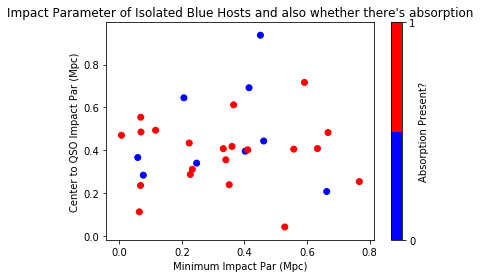

In [123]:
colormap = ListedColormap(['blue', 'red'])
plt.scatter(blue_hosts.query('center_QSO_rho < 1').min_dist, blue_hosts.query('center_QSO_rho < 1').center_QSO_rho, c=colormask, cmap=colormap)
cb=plt.colorbar(ticks=[0,1])
cb.set_label('Absorption Present?')
plt.xlabel('Minimum Impact Par (Mpc)')
plt.ylabel('Center to QSO Impact Par (Mpc)')
plt.title("Impact Parameter of Isolated Blue Hosts and also whether there's absorption");

Future work: maybe also find $\Delta \phi$ between group members and QSO.

In [124]:
blue_hosts

,party_size,QSO,redshift_guess,biggest_boi_z,vel_disp,radius,logmass,center_ra,center_dec,biggest_boi_gal_ra,...,stellar_masses,QSOrho_min,center_QSO_rho,host_vs_2nd_largest,delta_pos_angles,distances_to_largest,max_dist_to_largest,min_dist,group_name,absorption
0,3,J0226+0015,0.352969,0.349424,434.27875527748006 km / s,0.47554728663794493 Mpc,13.541019,36.550684,0.249508,36.550751,...,0 8.405740 10 8.493776 12 9.237293 N...,"12 212.200456 Name: rho_impact, dtype: float64",0.239549,0.180502,[99.01205342892192],"[0.8305753859114637, 0.35119949973112213]",0.830575,0.351199,J0226+0015_0.353,yes
1,3,J0226+0015,0.297729,0.297832,82.10966884351586 km / s,0.5454572807064169 Mpc,12.153837,36.534892,0.259185,36.510059,...,1 10.386827 3 8.162347 18 8.84550...,"18 309.147669 Name: rho_impact, dtype: float64",0.417939,0.028752,[39.148057129619794],"[0.36014567540456316, 1.0909145614128337]",1.090915,0.360146,J0226+0015_0.2977,yes
2,3,J0809+4619,0.520972,0.520903,170.96243529961782 km / s,0.4460492822060432 Mpc,12.703472,122.302953,46.331768,122.327316,...,30 8.682405 39 8.705125 49 9.479523 N...,"30 226.299365 Name: rho_impact, dtype: float64",0.355759,0.168113,[3.020439645889155],"[0.8920985644120765, 0.3404412353302686]",0.892099,0.340441,J0809+4619_0.521,yes
3,3,J0809+4619,0.532704,0.530117,64.25117503448554 km / s,0.2425109703073517 Mpc,11.588781,122.316879,46.342665,122.326057,...,40 9.084104 44 9.159035 47 11.03056...,"40 572.241914 Name: rho_impact, dtype: float64",0.691767,0.013442,[19.517995533384124],"[0.485021940614694, 0.4146818889551109]",0.485022,0.414682,J0809+4619_0.5327,no
6,3,J0843+4117,0.593428,0.593416,587.4728056954765 km / s,0.4896173058758222 Mpc,13.816120,130.961451,41.332694,130.936050,...,69 10.393711 90 8.713455 117 9.35...,"90 899.830087 Name: rho_impact, dtype: float64",0.936858,0.091290,[7.04908661386051],"[0.4510282355157211, 0.9792346117516444]",0.979235,0.451028,J0843+4117_0.5934,no
7,4,J0843+4117,0.579206,0.580030,741.130979407261 km / s,0.6160718164183764 Mpc,14.117709,130.958811,41.305138,130.938828,...,74 10.899514 84 9.720776 97 9.87...,"101 375.549683 Name: rho_impact, dtype: flo...",0.254085,0.142579,"[34.469395857192154, 0.419501258109392, 34.049...","[1.2321436328367528, 0.7674014062515297, 0.887...",1.232144,0.767401,J0843+4117_0.5792,yes
12,4,J0914+2823,0.600128,0.599377,210.4741084339208 km / s,0.4752470294288141 Mpc,12.911604,138.652848,28.389869,138.656982,...,137 10.191614 138 9.490131 141 11.04...,"141 303.581866 Name: rho_impact, dtype: flo...",0.340196,0.138638,"[1.087181911866935, 162.8818972573213, 161.794...","[0.24839155529185483, 0.24707328742404375, 0.7...",0.710290,0.247073,J0914+2823_0.6001,no
13,3,J0914+2823,0.227620,0.228207,240.27501987336456 km / s,0.251752369433876 Mpc,12.750678,138.694743,28.413870,138.675736,...,149 11.202757 153 9.994957 163 9.86...,"149 315.719541 Name: rho_impact, dtype: flo...",0.433909,0.061973,[34.65042406359683],"[0.22337841272957862, 0.5035047388677485]",0.503505,0.223378,J0914+2823_0.2276,yes
14,3,J0914+2823,0.310807,0.311144,561.4205251140576 km / s,0.44549509983645014 Mpc,13.735707,138.688157,28.386134,138.689453,...,150 8.158745 152 11.682953 154 8.63...,"150 314.999336 Name: rho_impact, dtype: flo...",0.311530,0.000895,[141.75255020516497],"[0.2331941078251866, 0.6960798245296334]",0.696080,0.233194,J0914+2823_0.3108,yes
16,3,J0935+0204,0.353180,0.349514,822.0843914831577 km / s,0.3401254094698518 Mpc,13.949760,143.823312,2.086358,143.810104,...,176 11.811457 181 10.423237 197 9.15...,"176 360.920261 Name: rho_impact, dtype: flo...",0.287324,0.040905,[28.629875810130883],"[0.22679497563174308, 0.6802508189397036]",0.680251,0.226795,J0935+0204_0.3532,yes


In [126]:
gal_info

,specfile,id,OBJECT,cgm_name_x,gal_ra,gal_dec,z,OII_flux,OII_flux_sig,OII_LQ,...,SFR_photo,match_ang_separation,logmhalo,rvir,rho_rvir,sSFR,Z_R23,Z_R23_flag,Z_Flag,friends_group
0,J022601.51+001532.5.fits,J022601.51+001532.5._03,J0226+0015,J0226+0015_271_194,36.506302,0.259040,0.352715,NaN,NaN,NaN,...,1.894698,9.669706e-09,10.860650,96.313076,10.328094,-6.511042,NaN,none,O3N2,0
1,J022602.41+001536.6.fits,J022602.41+001536.6._01,J0226+0015,J0226+0015_272_181,36.510059,0.260170,0.297832,NaN,NaN,NaN,...,0.228083,8.892883e-09,11.908800,224.417288,3.685016,-10.158744,NaN,none,NaN,1
2,J022606.98+001451.4.fits,J022606.98+001451.4._02,J0226+0015,J0226+0015_251_119,36.529079,0.247620,0.384662,4.200000e-17,5.280000e-18,1.0,...,35.912585,2.318738e-09,11.572587,162.502477,3.948948,26.077379,NaN,none,N2,2
3,J022607.08+001612.7.fits,J022607.08+001612.7._01,J0226+0015,J0226+0015_291_119,36.529518,0.270200,0.299556,NaN,NaN,NaN,...,0.655333,3.608513e-09,10.735680,91.083501,5.984588,-7.507014,NaN,none,N2,1
4,J022608.02+001427.2.fits,J022608.02+001427.2._03,J0226+0015,J0226+0015_237_115,36.533401,0.240880,0.506584,4.100000e-17,3.290000e-18,1.0,...,2.769872,2.426000e-08,11.114763,105.099983,6.943187,-6.099805,NaN,none,NaN,3
5,J022609.11+001513.1.fits,J022609.11+001513.1._01,J0226+0015,J0226+0015_258_82,36.537972,0.253650,0.496565,NaN,NaN,0.0,...,200.273364,5.085844e-10,12.403701,284.542106,1.805834,189.507753,NaN,none,NaN,4
6,J022610.26+001603.7.fits,J022610.26+001603.7._01,J0226+0015,J0226+0015_298_72,36.542740,0.267700,0.334506,NaN,NaN,NaN,...,2.298427,2.211278e-08,10.858702,97.481408,3.636310,-6.112105,NaN,none,NaN,5
7,J022610.44+001514.0.fits,J022610.44+001514.0._03,J0226+0015,J0226+0015_255_62,36.543480,0.253900,0.507057,5.970000e-17,3.550000e-18,1.0,...,103.043924,8.002066e-10,12.101398,224.049729,1.766947,92.505079,8.733941,upper w/ mass,R23,3
8,J022611.06+001323.6.fits,J022611.06+001323.6._02,J0226+0015,J0226+0015_202_136,36.546089,0.223230,0.474940,NaN,NaN,NaN,...,80.712525,1.119949e-09,11.709037,169.399713,4.913714,70.686793,NaN,none,NaN,6
9,J022611.40+001341.3.fits,J022611.40+001341.3._01,J0226+0015,J0226+0015_203_118,36.547489,0.228130,0.365194,1.560000e-17,3.340000e-18,1.0,...,3.730040,9.407547e-09,11.204854,124.288799,4.963415,-5.395472,8.968619,upper w/ mass,R23,7
